In [1]:
!pip install -qq pytorch-lightning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]  
        image = np.array(row.iloc[1:], dtype=np.uint8).reshape(28, 28, 1)
        label = row.iloc[0]  
        if self.transform:
            image = self.transform(image)
        return image, label

    def plot_image(self, idx):
        image, label = self.__getitem__(idx)
        image = image.numpy().squeeze()  
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')  
        plt.show()

In [6]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
batch_size = 32

train_dataset = MNISTDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

train_dataset = MNISTDataset(validation_df, transform=transform)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

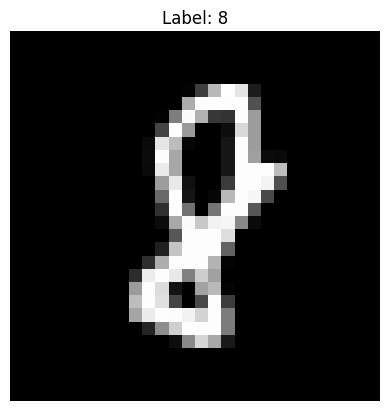

In [8]:
train_dataset.plot_image(0) 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy

class DigitNet(pl.LightningModule):
    def __init__(self, n_classes=10):
        super(DigitNet, self).__init__()
        # First block of convolutions and pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Second block of convolutions and pooling
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Correcting the number of input channels for conv6
        self.conv6 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(192 * 3 * 3, 256) 
        self.fc2 = nn.Linear(256, n_classes)
        
        # Metrics
        self.accuracy = Accuracy(task='multiclass',num_classes=n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(logits, y), on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y), on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [10]:
model = DigitNet(n_classes=10)

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
   dirpath="./checkpoints/mnist/",
   filename="DigitNet--{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

In [12]:
trainer = pl.Trainer(max_epochs=10, accelerator="auto", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

2024-08-09 07:20:37.570711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 07:20:37.570810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 07:20:37.698420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [14]:
class MNISTTestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Reshape the flat pixel array into 28x28 image
        image = self.dataframe.iloc[idx].values.reshape(28, 28, 1).astype(np.uint8)
        if self.transform:
            image = self.transform(image)
        return image

In [15]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.ToTensor(),    
    transforms.Normalize((0.5,), (0.5,))  
])


df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


test_dataset = MNISTTestDataset(df_test, transform=test_transform)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Shuffle is False for test data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  


predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predictions) + 1),
    'Label': predictions
})


submission.to_csv('mnist_predictions.csv', index=False)
print("Saved predictions to 'mnist_predictions.csv'")

Predicting: 100%|██████████| 438/438 [00:08<00:00, 50.76it/s]


Saved predictions to 'mnist_predictions.csv'
